In [1]:
# Step 1: Data Preperation

# The most common question I've gotten from students in the class so far is
# "how do I start?" It's a big project and can be daunting, so here are a couple
# of tips on how to get started!

# First, I like to bring in data I have, in this case the training set, and
# split it up right away into three subsets: train/test/holdout. I think it
# would be reasonable to do this by the event.id, but there are other ways too

import pandas as pd
import numpy as np
import cloudpickle
import sklearn
df=pd.read_csv("../../assets/assignment/df_train.csv.gz")
events=df['event.id'].unique()

train_set=events[0:100]
test_set=events[100:200]
holdout_set=events[200:300]

train=df.query("`event.id` in @train_set")
test=df.query("`event.id` in @test_set")
holdout=df.query("`event.id` in @holdout_set")

# You notice how I just hard coded some slices in and made the sets the same
# size. You don't have to do this, and in the end, you want to submit your models
# to the autograder using *all* of the data in this dataset. But this is real
# world data so there will be weird format errors, and having a clear holdout
# set will give you a chance to "fail fast" and see those errors crop up without
# having to submit to the autograder
    
# Speaking about the holdout dataset, it will not have a bunch of data in it, like
# race times. That would of course leak the results, and wouldn't be available in
# practice. The addendum to the assignment has this description, and I just copy
# and past it here and create the same thing. This ensures when I am playing with
# my models and then want to evaluate them I won't make a mistake and use a
# column incorrectly.

holdout=holdout.drop(
    columns=['time.end',
             'body.results_certificate',
             'event.results_posted',
             'event.results_posted',
             'event.results_certificate',
             'event.photos_available',
             'event.photos_faces',
             'event.photos_social_sharing',
             'event.results_searchable',
             'corral.id',
             'corral.name',
             'corral.wave',
             'corral.time.close',
             'corral.time.start',
             'result.duration.chip',
             'result.duration.pace',
             'result.rankings',
             'result.splits',
             'result.videos',
             'result.finished',
             'result.disqualified',
             'result.duration'])

# Also, I will garuntee in the holdout set there is data. At least 6 rows per race
holdout=df.groupby(["event.id","clean_categories.name"]).filter(lambda z: len(z)>5)

# So now when I test models agains this holdout data I can be fairly certain
# that it is indicative of future data. No garuntees, I still need to build robust
# models, but this is helpful!

/data1/home/brooksch/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (13,16,17,20,21,27,38,45,46,47,57,66,67,72,73,74,79,104,105,119,121,124) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# Step 2: Use the autograder!

# I gave you the autograder code, so a next great step is just to copy and paste
# that in your notebook and get used to how it works.
import pandas as pd
import numpy as np
import cloudpickle
import sklearn

# This code simulates the autograder. It is not the full autograder implementation
# but shares an API with the autograder. It expects that your fitted pipeline is
# submitted with the name pipeline.cloudpickle as demonstrated above. This object
# must implement the predict() function. This is done automatically by the sklearn
# Pipeline object if the last element of your pipeline is a classifier which has
# a predict() function. If you are not submitting a Pipeline, and want to do something
# different, you *must* have a predict() function of the same method signature, e.g.:
#
#   predict(self, X, **predict_params)->np.ndarray

# Load holdout data, in this case I'll simulate it by loading the training data
#df=pd.read_csv("../../assets/assignment/df_train.csv.gz")

# And evaluate on all 5k races that we didn't consider for training
#holdout_data=df.query("`event.id`!='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")
holdout_data=holdout

# This is the scoring function to determine model fitness
def score(left: pd.DataFrame, right: pd.DataFrame):
    '''
    Calculates the difference between the left and the right when considering rank of items. 
    This scoring function requires that the two DataFrames have identical indicies, and that
    they each contain only one column of values and no missing values.
    '''
    assert(type(left)==pd.DataFrame)
    assert(type(right)==pd.DataFrame)
    assert(len(left)==len(right))
    assert(not np.any(np.isnan(left)))
    assert(not np.any(np.isnan(right)))
    assert(left.index.equals(right.index))
    # convert to ndarrays
    left=left.squeeze()
    right=right.squeeze()
    return np.sum(np.abs(left-right))/(len(left)*(len(left)-1))

# This function runs the prediction model agains a given event/category pair. It
# intentionally loads the student model each time to avoid accidental leakage of data
# between events.
def evaluate(data, pipeline_file='pipeline.cloudpickle'):
    # Load student pipeline
    fitted_pipe = cloudpickle.load(open(pipeline_file,'rb'))
    
    # Separate out the X and y
    X=list(set(data.columns)-{'overall_ranking'})
    y=['overall_ranking']
    
    # Drop any missing results (DNFs)
    data=data.dropna(subset=['overall_ranking'])
    
    # Ensure there is data to actually predict on
    if len(data)==0:
        return np.nan

    # Predict on unseen data
    from IPython.utils import io
    with io.capture_output() as captured:
        predictions=pd.DataFrame(fitted_pipe.predict(data[X]),data.index)
    observed=data[y]
    
    # Generate rankings within this bracket
    observed=pd.DataFrame(data[y].rank(),data.index)

    # Return the ratio of the student score
    return pd.Series({"score":score(observed,predictions)})

# Student solution
pipeline_file='pipeline.cloudpickle'

def autograde(data_held_out):
    # Run prediction on each group
    results=data_held_out.groupby(["event.id","clean_categories.name"]).apply(evaluate, pipeline_file)

    # Display the results, uncomment this for your own display
    results.reset_index()['score'].plot.bar();

    # This is the student final grade
    print(np.average(results))

In [3]:
# Step 3: Think about the task

# Supervised machine learning tasks are generally split into either classification tasks
# (picking a label, like cat or dog) or regression tasks (picking a number on a scale,
# like 1, or 5). This task is actually an ordinal prediction task -- if you look at the
# autograder code each individual runner will be given a place based on rank, and ties
# are settled by averaging the ranks (check the DataFrame.rank() function for details).

# A reasonable first approach would be to consider this a regression problem, and you
# could either predict rank of a person directly or the time it takes them to run and then
# use this to infer rank after the prediction has happened. Predicting rank directly
# is more challenging when you have races of varying size, and if you go that route
# you make want to predict percentile or the like and then convert it into rank. I think
# predicting time, which is independent between runners, is likely a more fruitful approach,
# but I haven't done these yet. Let's assume we wanted to predict based on time, we
# can get this out of the data and create our y value

y=pd.to_timedelta(train['result.duration.chip']).astype(int)

/tmp/ipykernel_27497/1142532581.py:18: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  y=pd.to_timedelta(train['result.duration.chip']).astype(int)


/data1/home/brooksch/.conda/envs/python3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0.3383756805740286


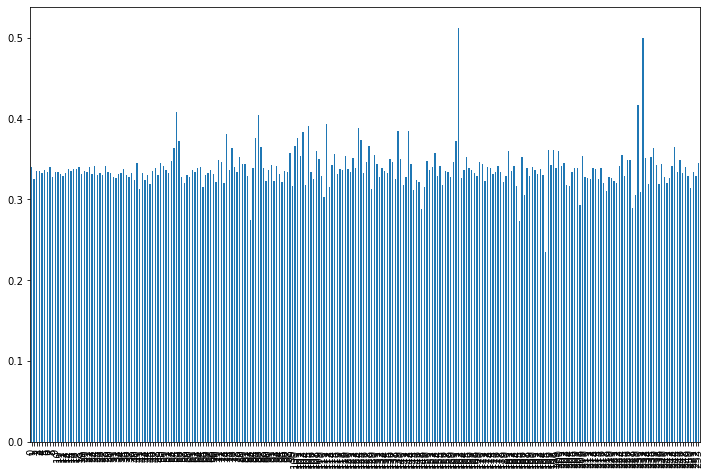

In [4]:
# Step 4: Think about the predictive modelling workflow

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

# Now that we have out outcome to predict, we want to think about what variables might
# be useful in predicting this. For running it's well known that sex and age have impacts
# at a population level, so we can start with those. But while age is numeric, sex is not.
# If you look at the data, you'll see that sex actually has a host of different values,
# and you can think about how to clean those. But for linear regression we need to make
# this numeric. While there are various ways to do this, one hot encoding is a pretty
# common one. So the strategy for this first model is to one hot encode sex with a binary
# split of Male/Female, and to just use age as is, and train a linear regression model
# with default parameters and then convert that timing into a ranking down the road.

# There are several ways to do this. The autograder is expecting that you will have
# saved a python object and that it has a predict(X) function where X is a pandas
# DataFrame object that has all of the columns in the holdout data but only for one
# combination of event.id and clean_categories.name. There are two high level strategies
# here:
#  1. Roll your own object, where you create your own object that has the predict()
#     function and just does all the work in there however you want it to.
#  2. Use sklearn.pipeline.Pipeline objects, where you leverage some of the resuable
#     sklearn pipeline objects which were build for this purpose.

# Importantly, there are non-exclusive options, and you can blend however you see fit.
# I'll show examples of both, first being the roll your own

def roll_own()->object:
    """This function returns a fitted object with a predict(x) function"""
    
    # First I'm going to create a new class with a predict function, and that class
    # is just going to call the regression object it is setup with and then rerank
    # all of the values which come back
    class RollingRegressor():
        
        # For this class I'm going to assume it has been given a fitted model, so
        # I'm choosing not to implement the fit() function.
        def __init__(self, fitted_model):
            self.regressor=fitted_model
        
        # For the prediction we are just given our dataframe, so we have to do our
        # data cleaning here.
        def predict(self, X):
            # We need to be careful and *not* drop rows. The autograder is expecting
            # a rank back for every row in X! Lets just grab out the two columns of
            # interest
            df=X[["age","sex"]]
            
            # For brevity let's get rid of any sex that isn't Male/Female and replace with nan
            # A better approach would be to inspect and map this data accordingly, but I'll leave
            # that as an enhancement.
            df.loc[df.query("`sex` not in ['Male','Female']").index, 'sex']=np.nan
            
            # Now that this is binary we can convert this column into a numeric value
            df.loc[df.query("`sex` == 'Male'").index, 'sex']=1
            df.loc[df.query("`sex` == 'Female'").index, 'sex']=0
            
            # Now just do whatever you want with missing values, this below doesn't seem ideal
            df=df.fillna(-1)
            
            # With the data cleaning done, we can now predict the times for our data
            times=self.regressor.predict(df)
            
            # We can't return the times directly - the autograder wants ranks. We can
            # use a similar method those to return ranks
            return times.squeeze().argsort()+1
    
    # Our return class is done, now we just need to initalize it with a fitted
    # model. To fit the model we just do all of the cleaning over, and add in some training.
    # It would be a better ideal to put this all in the class itself, but I want to
    # show you that this isn't needed -- the autograder is NOT going to try and fit()
    # your model, it is only going to call predict(), so you can do whatever you want
    # within that predict()
    
    df=train[["age","sex"]]
    df.loc[df.query("`sex` not in ['Male','Female']").index, 'sex']=np.nan
    df.loc[df.query("`sex` == 'Male'").index, 'sex']=1
    df.loc[df.query("`sex` == 'Female'").index, 'sex']=0
    df=df.fillna(-1)
    
    # Since we have decided it's a regression problem, we can decide to use a simple linear
    # model for our first attempt too, so I'll create that now
    from sklearn.linear_model import LinearRegression
    reg=LinearRegression()
    reg.fit(df,y)
    
    # Now we just return the object that the autograder will want
    return RollingRegressor(reg)
    
# We can test this out by instantiating it
fitted_reg=roll_own()
# Then saving it to a file
cloudpickle.dump(fitted_reg, open('pipeline.cloudpickle','wb'))
# Then telling the autograder function to fire
autograde(holdout)

Pipeline(steps=[('cleaner',
                 ColumnTransformer(transformers=[('sex',
                                                  OneHotEncoder(categories=[['Male',
                                                                             'Female']],
                                                                handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('age', 'passthrough',
                                                  ['age'])])),
                ('fix_nans', SimpleImputer(fill_value=-1, strategy='constant')),
                ('regressor',
                 TransformedTargetRegressor(inverse_func=<function evaluation_function at 0x7f4cd5a091f0>,
                                            regressor=LinearRegression()))])

/data1/home/brooksch/.conda/envs/python3.8/lib/python3.8/site-packages/sklearn/compose/_target.py:181: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(


0.345257961666107


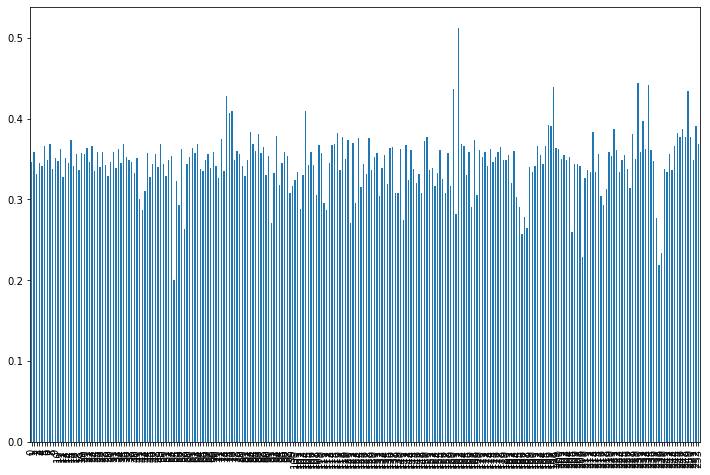

In [5]:
# That assignment should pass the autograder. A more pythonic way to do this, and certainly
# the goal of the sklearn team, is to use pipelines, and reuse transformer objects to do the
# data cleaning. In sklearn pipelines are made up of a sequence of Transformers with the last
# item in the pipeline being an Estimator. You can have Estimators throughout the pipeline
# too, creating new features through modeling. For instance, you could use PCA to reduce the
# dimensionality of features and then learn on principal components instead.

plt.figure(figsize=(12, 8))

# We can write a similar model to the above using pipelines and transformers. A good example
# would be to first create a transformer for the columns of sex and age, and get rid of
# everything else while one hot encoding sex
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
cleaner = ColumnTransformer(
    transformers=[
        ("sex", OneHotEncoder(categories=[['Male','Female']], handle_unknown='ignore'), ['sex']),
        ('age', 'passthrough', ['age']),
    ], remainder='drop')

# Then we create a three stage pipeline, where the first step applies the column transformer,
# the next step fills our missing values, and the third step is a regression model. But remember,
# this isn't a simple regression, we need an ordinal classification. To do this we can wrap
# the linear regressor in another class which will transform the regression output. This class
# is called the TransformedTargetRegressor, and we can tell it what function we want to apply
# to the final output before returning the predictions.

def evaluation_function(x):
    '''Must return a ndarray of the rankings in order, the autograder will then create
    a dataframe out of this with x.index as the index. Props to Rachell Calhoun!'''
    return pd.Series(x.squeeze()).rank().values

# We can wrap a linear regressor by setting the inverse_func to evaluation_function
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
reg=TransformedTargetRegressor(regressor=LinearRegression(), inverse_func=evaluation_function)

# Now we can build our three part pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
pipe = Pipeline(
    steps=[
        ("cleaner", cleaner),
        ("fix_nans", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
        ("regressor", reg)
    ])

# We can display the pipeline to see what it looks like and get a sense of data flow
from sklearn import set_config
set_config(display="diagram")
display(pipe)

# We can then fit the data in the pipeline
fitted_pipe=pipe.fit(train,y)

# And we can save it to an output file
cloudpickle.dump(fitted_pipe, open('pipeline.cloudpickle','wb'))
# Then telling the autograder function to fire
autograde(holdout)